Task Description : Given a system description, we need to find a good policy to control this system. The system in question is a cart on a flat 1D surface. Actuator can create a force F acting on the car in either direction. Goal is to 1) stay as close to the middle as possible; 2) minimize the work of your actuator. 

Solution : The solution has been Implemented using a DQN agent which I had implmeneted some time ago. 

The action space consists of 2 discrete actions(+F,-F). Currently I have given a fixed force of 10N 
The observation space consists of 2 values, current position of the agent, Initial  velocity for next step(final velocity of previous step). 
Negation of Absolute distance between center of the surface and the current position of an agent is considered as reward, as depicted in the figure below 
A high negative reward is awarded if the agent taken actions such that it breaks out of the observation space.

Instructions:
The only variable here is start and end value of flat 1d surface. It can be set to desired values during its initiation. The rest of code is self explainatory

![title](Task_description.jpg)

In [1]:
# Necessary Imports
import random
import gym
import numpy as np
from collections import deque
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from gym import spaces
from numpy.random import default_rng
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
%matplotlib inline

In [2]:
# Creating a class Environment matching the description
class Cart_1d(gym.Env):

    def __init__(self, pos_low, pos_high):

        self.cart_mass = 0.1
        self.tau = 0.05  # time between states update
        self.force = 10.0  # A fixed force of 10N, It can be a variable too in a different scenario
        self.v = 0

        self.pos_low = pos_low
        self.pos_high = pos_high
        assert self.pos_high > self.pos_low

        self.rng = default_rng()

        # Action space with 2 actions ( +F/-F )
        self.action_space = spaces.Discrete(2)

        self.low = np.array([self.pos_low, -np.finfo(np.float32).max],dtype = np.float32)
        self.high = np.array([self.pos_high, np.finfo(np.float32).max], dtype = np.float32)
        # creating an observation space containing agent position and intial velocity for next step
        self.observation_space = spaces.Box(self.low, self.high, dtype=np.float32)

        self.state = None

    def step(self, action):
        if action == 1:
            force_mag = self.force
        else:
            force_mag = -self.force

        X, u = self.state

        # F = ma
        a = force_mag / self.cart_mass
        # v = u + at
        self.v = u + a * self.tau
        # s = ut + (1/2)a(t)^2
        self.d = np.float32((u * self.tau) + (0.5 * a * (self.tau ** 2)))
        # Current step final velocity is next step initial velocity
        u = self.v
        # Next Position
        X += self.d
        # Force end episode if the observation space bounds are breached
        done = bool(X > self.pos_high or X < self.pos_low)

        if not done:
            reward = -np.abs(((self.pos_low + self.pos_high) / 2) - X)
        else:
            reward = -(2 * self.pos_high)  # high negaive for going Out of range

        self.state = (X, u)

        return np.array(self.state,dtype=np.float32), reward, done, {}

    def reset(self):
        reset_pos = self.rng.uniform(low=self.pos_low, high=self.pos_high, size=1)
        reset_pos = reset_pos.astype('float32')
        # reset position randomly in observation space and velocities to zero
        self.state = np.array([reset_pos, 0],dtype=np.float32)
        self.v = 0

        return np.array(self.state, dtype=np.float32)

    def render(self, mode='human', close=False):
        # Can be used for visulization in Future
        pass


In [3]:
# envrn = Cart_1d(0,100) # set it to desired values of lower and upper limit of flat 1d surface

In [4]:
# This is a DQN Controller which I had implemented some time back and using the same since I get the flexibility for visualization during training
class DQNController:
    """This class represents the DQN learning algorithm."""

    def __init__(self, environment):
        self.env = environment
        self.n_states = self.env.observation_space.shape[0]

        # Hyperparameters
        self.n_states = self.env.observation_space.shape
        self.memory = deque(maxlen=500000)
        self.epsilon_min = 0.0001
        self.gamma = 0.99
        self.epsilon = 0.9
        self.epsilon_decay = 0.95
        self.learning_rate = 0.001 #0.0007
        self.batch_size = 16

        self.online_network = Sequential(
            [
                Dense(64, activation="relu", input_shape=self.n_states),
                Dense(16, activation="relu", ),
                Dense(self.env.action_space.n),
            ]
        )
        self.target_network = Sequential(
            [
                Dense(64, activation="relu", input_shape=self.n_states),
                Dense(16, activation="relu", ),
                Dense(self.env.action_space.n),
            ]
        )
        # Start both networks with same initialization
        self.target_network.set_weights(self.online_network.get_weights())
        # Compile online network
        self.online_network.compile(loss="mse", optimizer=Adam(lr=self.learning_rate), metrics=['accuracy'])

    def decide(self, observation):
        """Takes a decision in an epsilon-greedy way"""
        # Feature Normalization can be done here, not implemented here
        if self.epsilon < np.random.rand(1):
            action = np.argmax(self.online_network.predict(np.array([observation])))
        else:
            action = random.choice(range(self.env.action_space.n))

        return action


    def _deliberate(self, observation, reward=0, done=False):
        """Deliberate over what happened. This function contains the main
        logic for the DQN algorithm."""

        if len(self.memory) < self.batch_size:
            return

        # sample from experience
        samples = random.sample(self.memory, self.batch_size)

        # seperating states and next_states for prediction
        state_for_pred = []
        next_state_for_pred = []
        for i in range(len(samples)):
            state_for_pred.append(samples[i][0])
            next_state_for_pred.append(samples[i][3])

        # Collect all predictions
        next_pred = self.target_network.predict_on_batch(np.array(next_state_for_pred))
        current_pred = self.online_network.predict_on_batch(np.array(state_for_pred))

        # collecting states to fit
        target_list = np.empty((0, self.env.action_space.n))
        state_coll = []

        for sample, i in zip(samples, range(len(samples))):
            state, action, reward, new_state = sample
            state_coll.append(state)
            target = [list(current_pred[i])]
            if done:
                target[0][action] = reward
            else:
                Next_Q_value = max(next_pred[i])
                target[0][action] = reward + Next_Q_value * self.gamma
            target_list = np.vstack((target_list, target))
        # Train model on batch
        self.online_network.train_on_batch(np.array(state_coll), target_list)


    # Training 
    def train(self, n_episodes=150, max_episode_len=2500, visualize=True):    
        self.training_mode = True
        train_log = {'cum_rew': []}
        self.a = self.env.observation_space.high[0]
        self.b = self.env.observation_space.low[0]
        for ep in tqdm(range(n_episodes)):
            state = self.env.reset()
            k = 0
            cum_rew = 0
            done = False
            states_collect=[]
            while not done:
                action = self.decide(state)
                # Agent's position to visualize
                if visualize:
                    states_collect.append(state[0])
                next_state, reward, done, _ = self.env.step(action)
                done = done or k == (max_episode_len - 1)  # force done after max_episodes
                self.memory.append([state, action, reward, next_state])
                self._deliberate(next_state, reward, done)
                state = next_state
                # update target network after every 800 steps
                if k % 800 == 0:
                    self.target_network.set_weights(self.online_network.get_weights())
                k += 1
                cum_rew += reward
            print("Cumulative Reward per step of Episode "+str(ep)+" is " + str(cum_rew / k))
            train_log['cum_rew'].append(cum_rew / k)
            if visualize:
                plt.plot(states_collect)
                plt.grid()
                plt.xlabel("Episode Steps")
                plt.ylabel("Agent Position")
                # tolerance allowance of +/- 2 to create a nice expectation band in visualization
                lower_bound = ((self.a + self.b)/2) - 2
                upper_bound = ((self.a - self.b)/2) + 2
                plt.axhspan(lower_bound,upper_bound, color='green', alpha=0.5)
                plt.show()

            # Epsilon decay every episode
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            elif self.epsilon <= self.epsilon_min:
                self.epsilon = self.epsilon_min

            # to be sure exploration is at minimun before entering testing mode
            if ep == (n_episodes - 1):
                self.epsilon = 0

        return train_log
        
    # Testing    
    def test(self, n_episodes=20, max_episode_len=1000, visualize=False):
        self.training_mode = False
        log = {'cum_rew': []}
        for ep in tqdm(range(n_episodes)):
            state = self.env.reset()
            k = 0
            cum_rew = 0
            done = False
            states_collect = []
            while not done:
                action = self.decide(state)
                if visualize:
                    states_collect.append(state)
                state, reward, done, _ = self.env.step(action)
                done = done or k == (max_episode_len - 1)  # force done after max_episodes
                k += 1
                cum_rew += reward
                if visualize:
                    plt.plot(states_collect)
                    plt.grid()
                    plt.xlabel("Episode Steps")
                    plt.ylabel("Agent Position")
                    # tolerance allowance of +/- 2 to create a nice expectation band in visualization
                    lower_bound = ((self.a+self.b)/2) - 2
                    upper_bound = ((self.a-self.b)/2) + 2
                    plt.axhspan(lower_bound,upper_bound, color='green', alpha=0.5)
                    plt.show()
            log['cum_rew'].append(cum_rew / k)
        print(f'tested for {ep + 1} episodes')
        return log

In [5]:
# Agent Instance is created with DQNcontroller and cart_1d environment
agent = DQNController(Cart_1d(pos_low=0.0,pos_high=100.0)) # set it to desired values of lower and upper limit of flat 1d surface

Reward of Episode 0 is -30.314231626449093


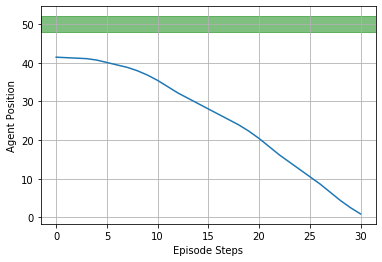

Reward of Episode 1 is -22.799939443898754


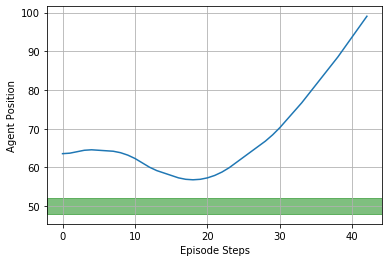

Reward of Episode 2 is -32.68757655702788


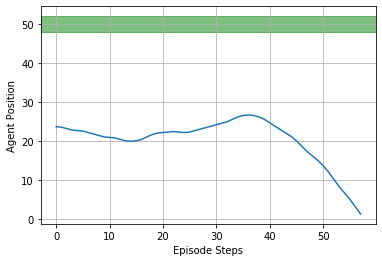

Reward of Episode 3 is -20.655604138581648


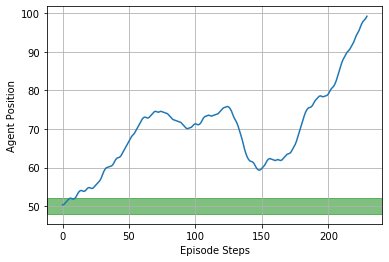

Reward of Episode 4 is -25.11370972912721


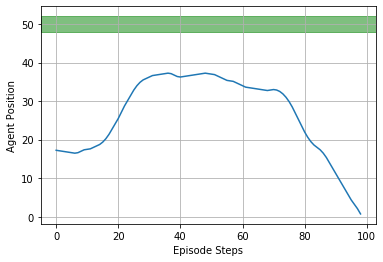

Reward of Episode 5 is -51.80650288349873


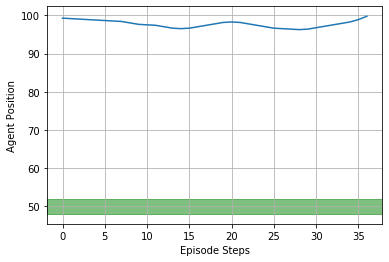

Reward of Episode 6 is -39.74836331694873


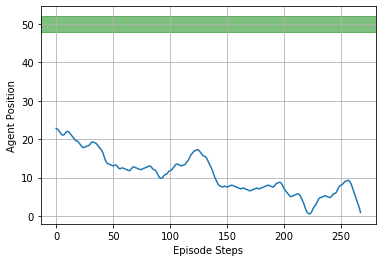

Reward of Episode 7 is -18.8849724609375


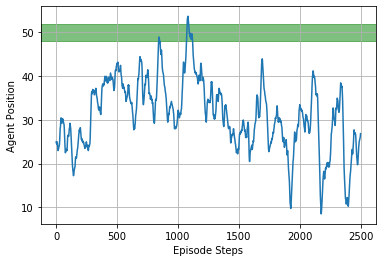

Reward of Episode 8 is -18.581775317382814


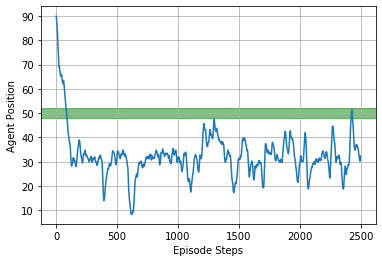

Reward of Episode 9 is -14.793258982849121


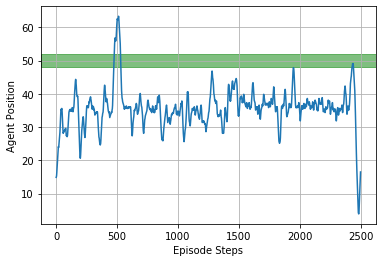

Reward of Episode 10 is -15.752754681396484


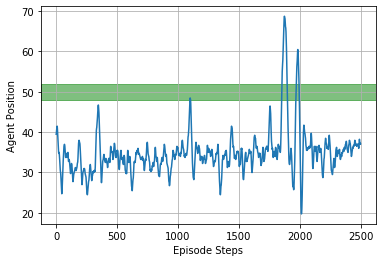

Reward of Episode 11 is -14.252782287597656


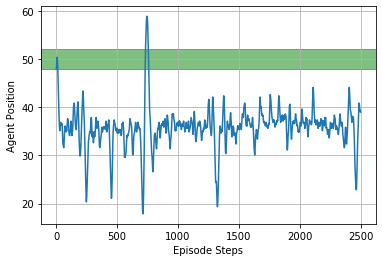

Reward of Episode 12 is -13.851394482421876


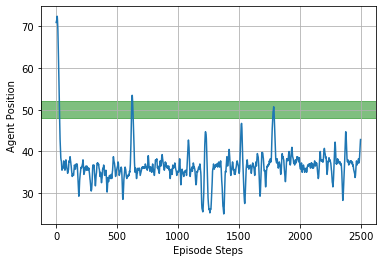

Reward of Episode 13 is -13.27565779647827


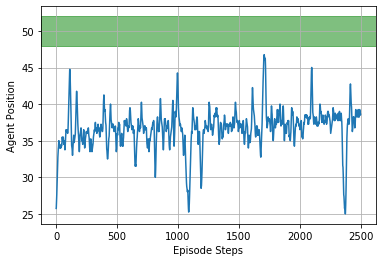

Reward of Episode 14 is -13.066496350097657


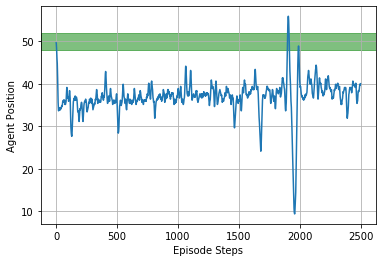

Reward of Episode 15 is -10.861428210449219


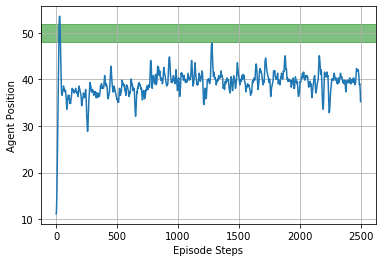

Reward of Episode 16 is -10.52621762769083


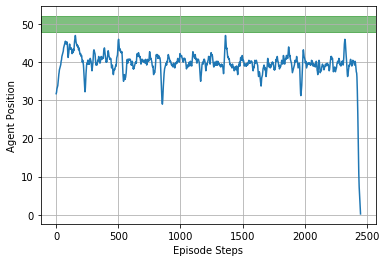

Reward of Episode 17 is -12.717594262695313


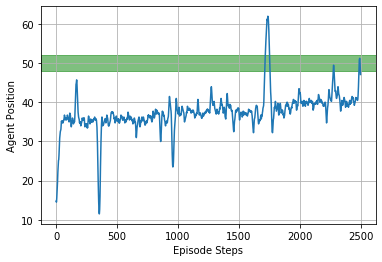

Reward of Episode 18 is -12.570480810546876


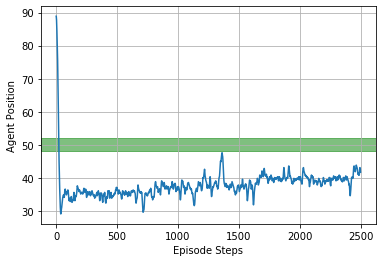

Reward of Episode 19 is -8.741843469238281


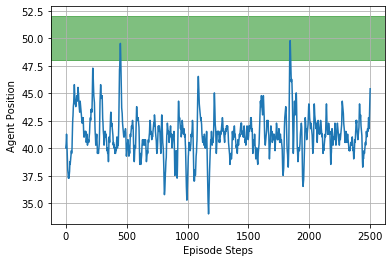

Reward of Episode 20 is -11.302757284545898


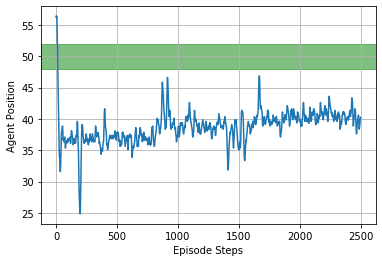

Reward of Episode 21 is -10.799093707275391


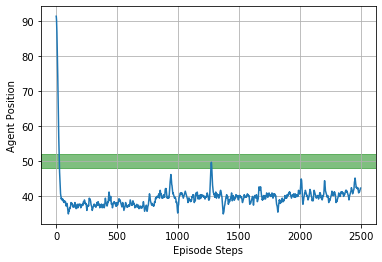

Reward of Episode 22 is -8.8705087890625


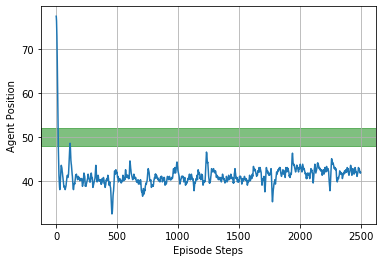

Reward of Episode 23 is -8.669794952392579


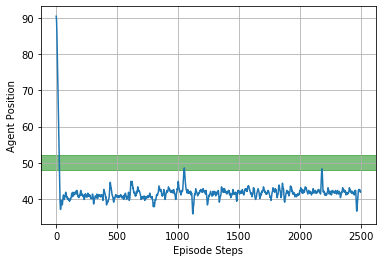

Reward of Episode 24 is -10.228654891967773


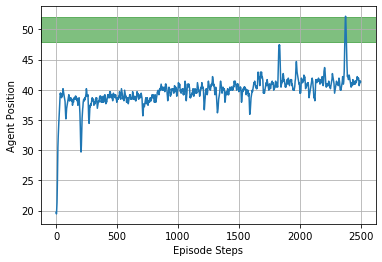

Reward of Episode 25 is -8.590009954833985


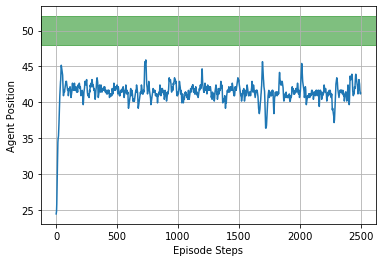

Reward of Episode 26 is -9.386701262664795


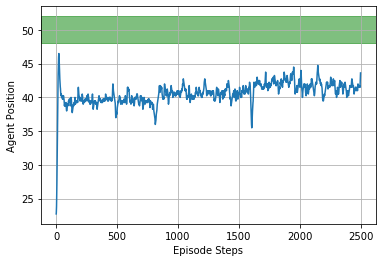

Reward of Episode 27 is -9.124958618164062


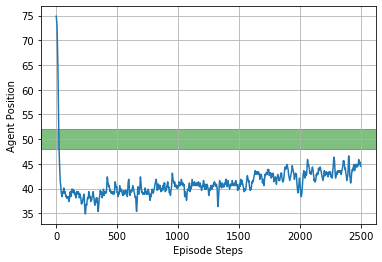

Reward of Episode 28 is -8.084870526123046


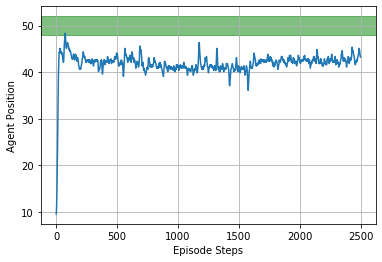

Reward of Episode 29 is -7.641567041015625


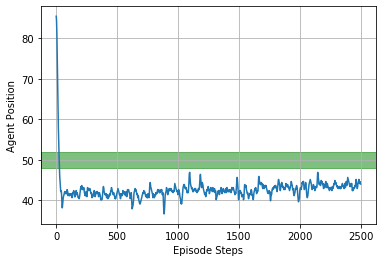

Reward of Episode 30 is -6.321730395507813


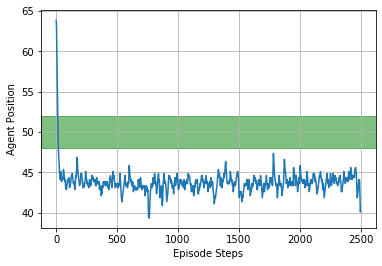

Reward of Episode 31 is -8.907462506103515


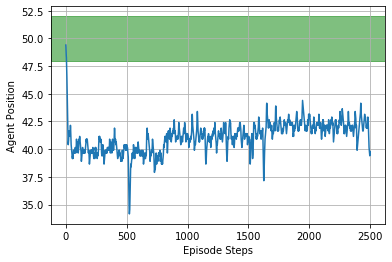

Reward of Episode 32 is -8.673944659423828


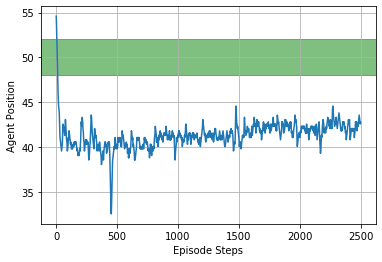

Reward of Episode 33 is -9.040320692443848


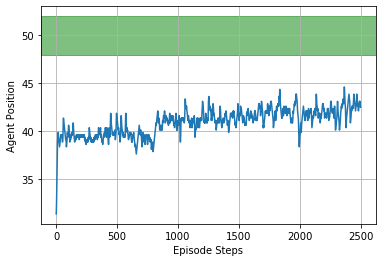

Reward of Episode 34 is -8.100606140136719


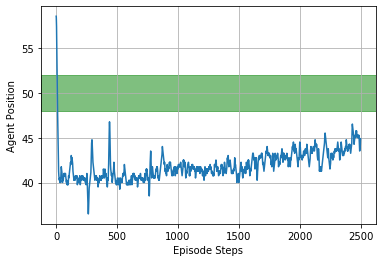

Reward of Episode 35 is -5.11430905456543


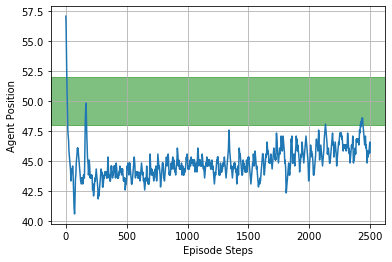

Reward of Episode 36 is -4.945698449707031


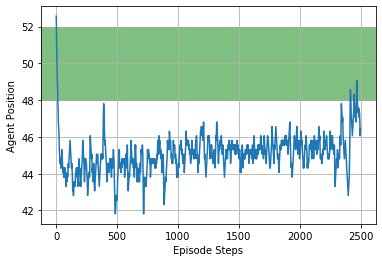

Reward of Episode 37 is -4.682978717041015


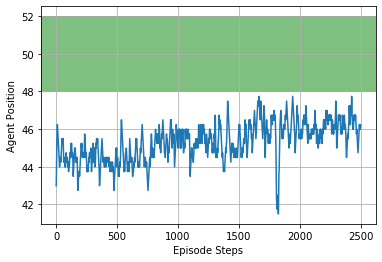

Reward of Episode 38 is -3.7011466430664064


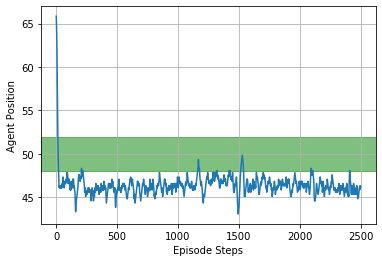

Reward of Episode 39 is -6.569057008361816


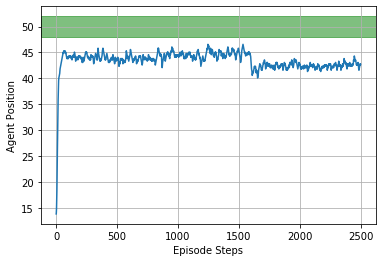

Reward of Episode 40 is -7.137870355224609


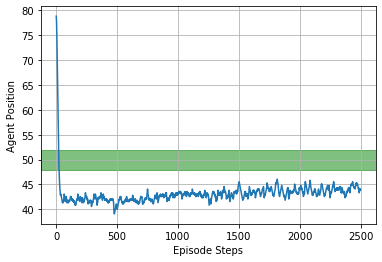

Reward of Episode 41 is -5.872373364257813


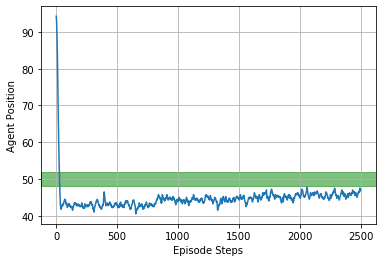

Reward of Episode 42 is -3.5771528259277345


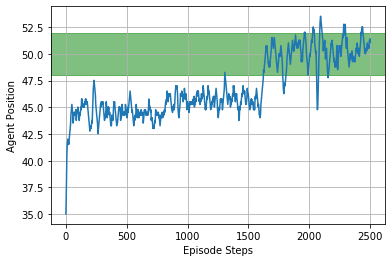

Reward of Episode 43 is -1.9925378723144531


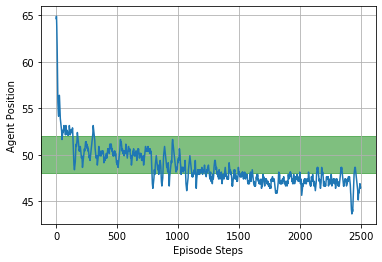

Reward of Episode 44 is -2.7195530670166015


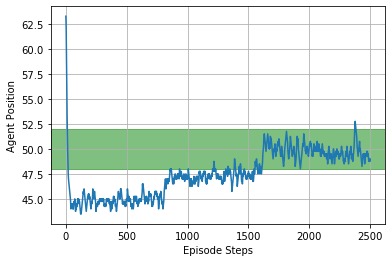

Reward of Episode 45 is -3.3705923645019533


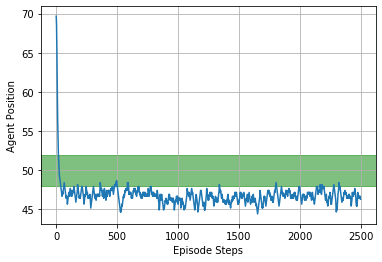

Reward of Episode 46 is -3.48655205078125


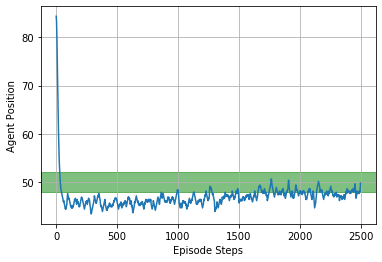

Reward of Episode 47 is -3.601038232421875


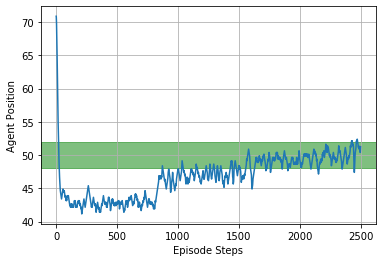

Reward of Episode 48 is -1.21571962890625


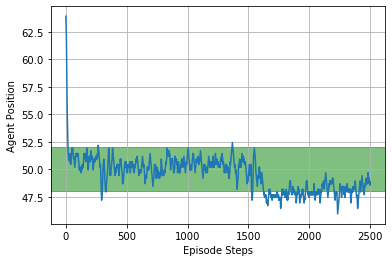

Reward of Episode 49 is -2.5779867492675783


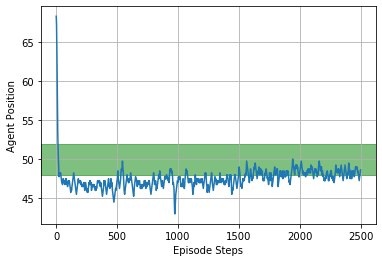

Reward of Episode 50 is -0.817396484375


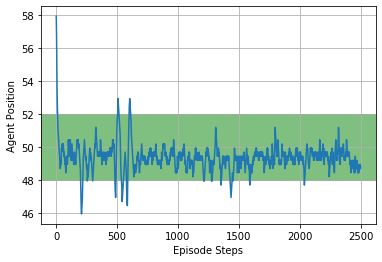

Reward of Episode 51 is -2.0526544555664064


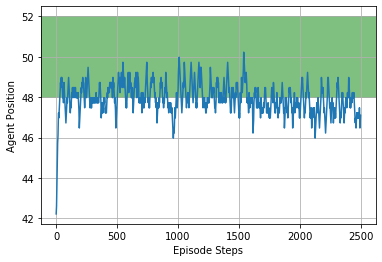

Reward of Episode 52 is -4.915687924194336


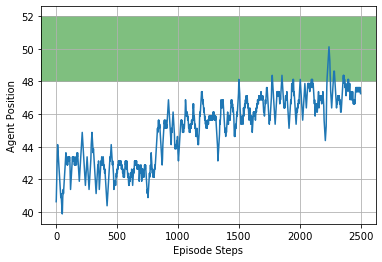

Reward of Episode 53 is -1.2529911743164062


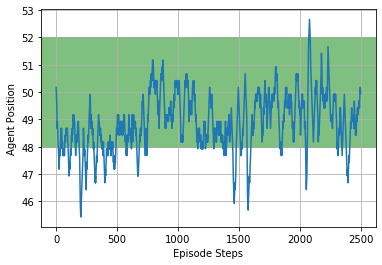

Reward of Episode 54 is -3.3433314208984375


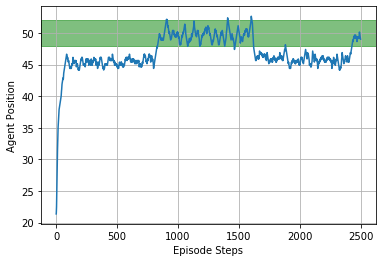

Reward of Episode 55 is -2.3658781372070314


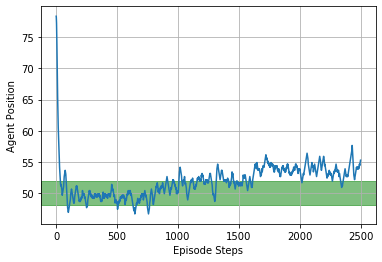

Reward of Episode 56 is -3.068148083496094


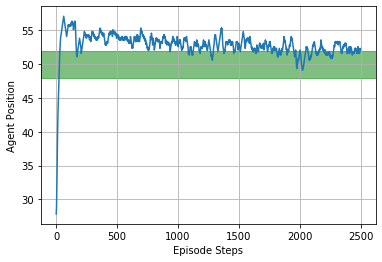

Reward of Episode 57 is -1.0345462448120117


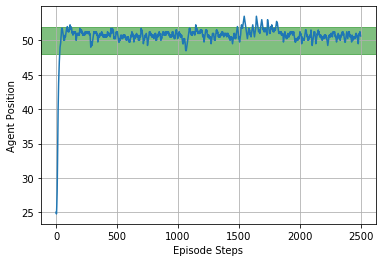

Reward of Episode 58 is -0.9494329612731933


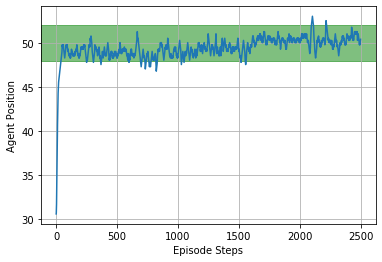

Reward of Episode 59 is -0.860562703704834


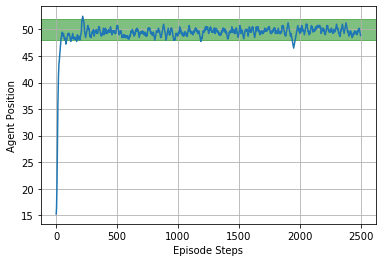

Reward of Episode 60 is -1.569484375


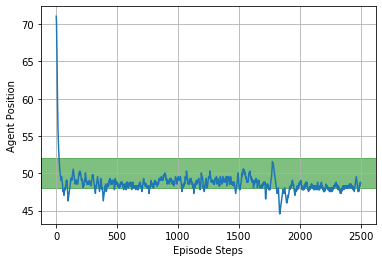

Reward of Episode 61 is -3.2974808044433592


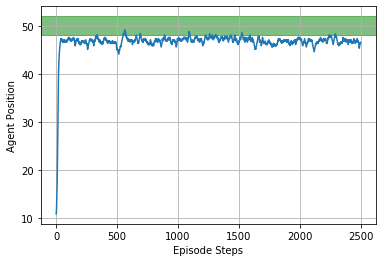

Reward of Episode 62 is -3.081826093292236


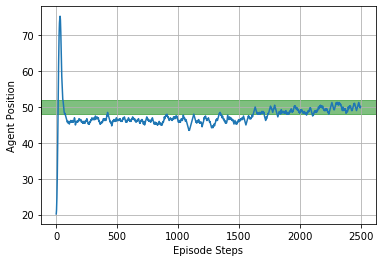

Reward of Episode 63 is -1.7982845985412597


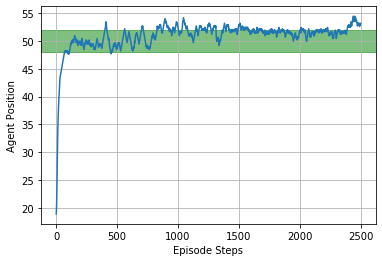

Reward of Episode 64 is -3.9591906860351562


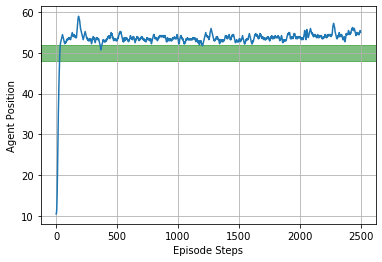

Reward of Episode 65 is -2.3675896484375


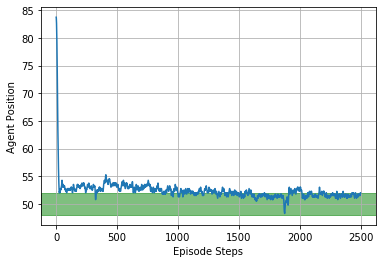

Reward of Episode 66 is -0.9242485389709473


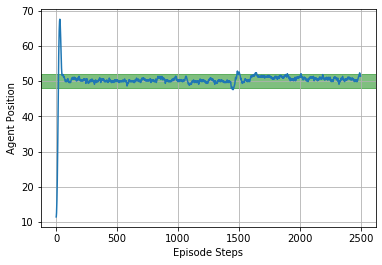

Reward of Episode 67 is -1.6890736083984375


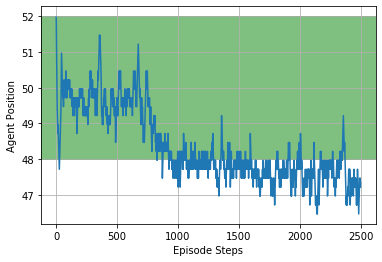

Reward of Episode 68 is -2.5603341117858887


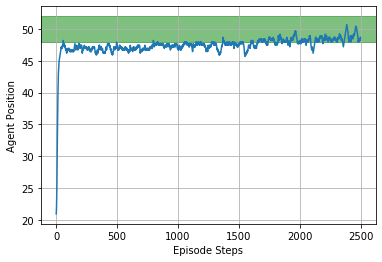

Reward of Episode 69 is -3.3435219360351565


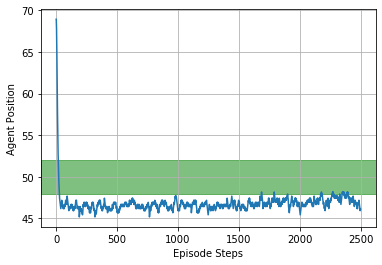

Reward of Episode 70 is -3.391730749130249


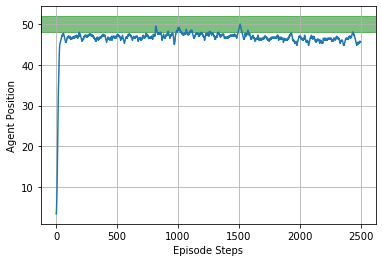

Reward of Episode 71 is -3.4566864013671874


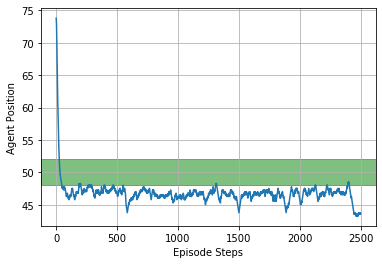

Reward of Episode 72 is -2.3970646484375


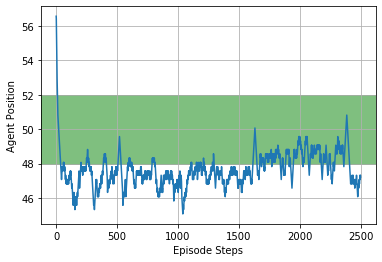

Reward of Episode 73 is -3.10081061668396


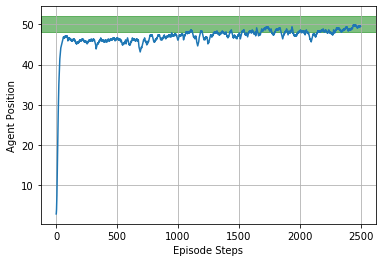

Reward of Episode 74 is -1.03591923828125


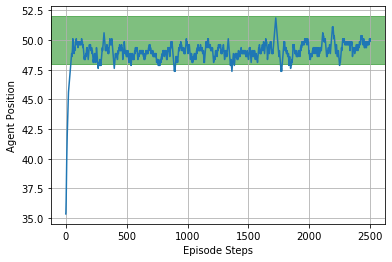

Reward of Episode 75 is -1.3696400583267212


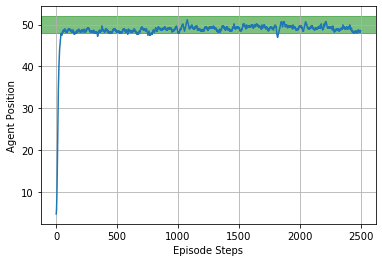

Reward of Episode 76 is -1.3843434448242187


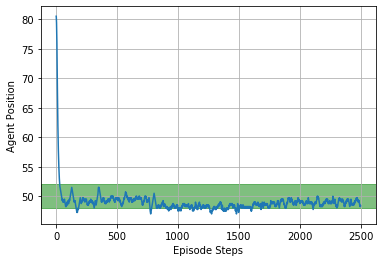

Reward of Episode 77 is -1.4801100280761719


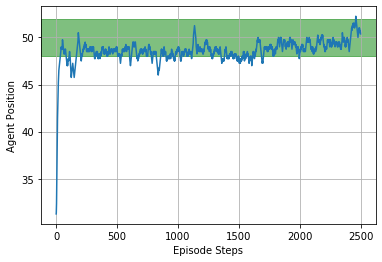

Reward of Episode 78 is -2.921840673828125


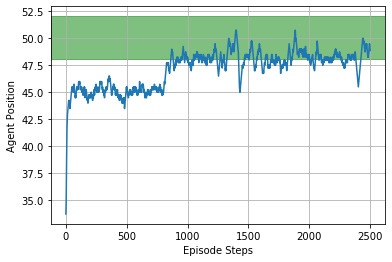

Reward of Episode 79 is -1.447667657470703


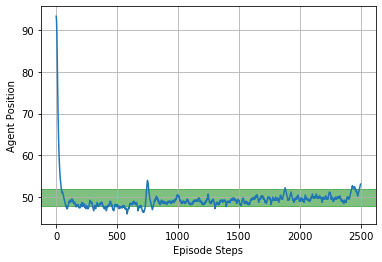

Reward of Episode 80 is -2.52774951171875


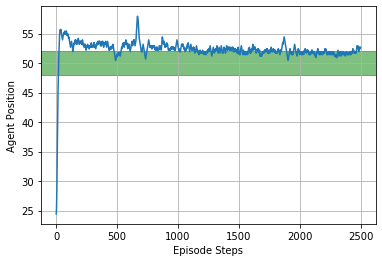

Reward of Episode 81 is -0.7323381378173828


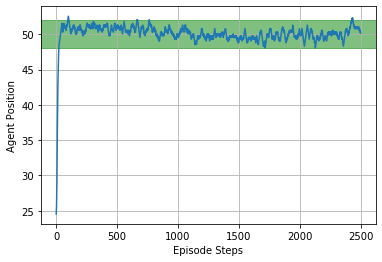

Reward of Episode 82 is -1.1901618030548096


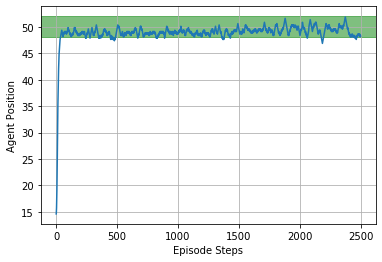

Reward of Episode 83 is -1.6104481567382813


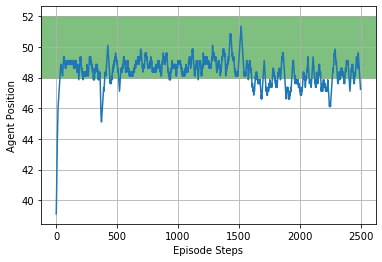

Reward of Episode 84 is -1.6313940673828125


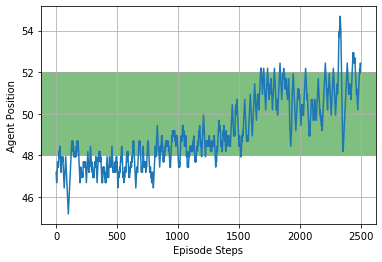

Reward of Episode 85 is -4.2633892578125


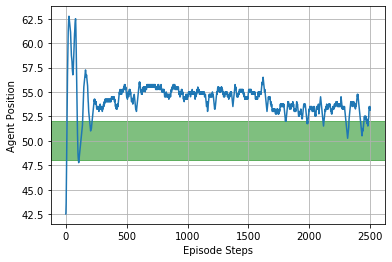

Reward of Episode 86 is -1.5013892944335938


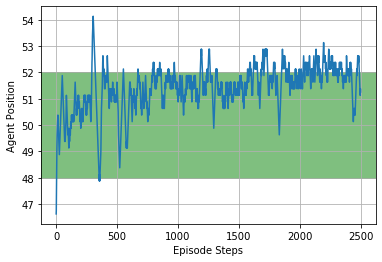

Reward of Episode 87 is -0.9380372314453125


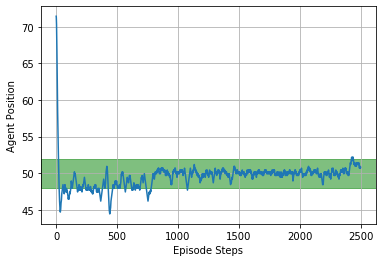

Reward of Episode 88 is -0.6643500122070313


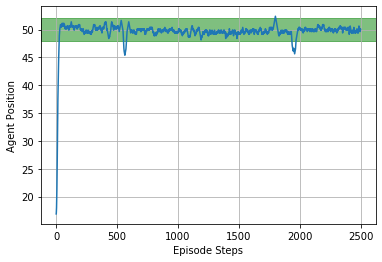

Reward of Episode 89 is -2.3440528800964358


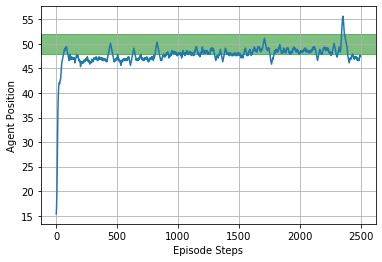

Reward of Episode 90 is -2.0961685340881346


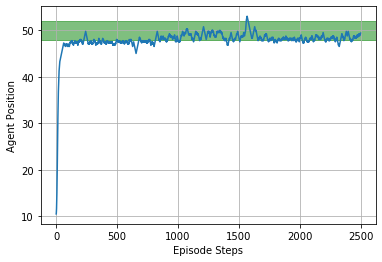

Reward of Episode 91 is -0.9070068115234375


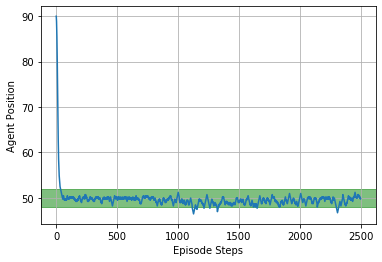

Reward of Episode 92 is -0.5262376678466797


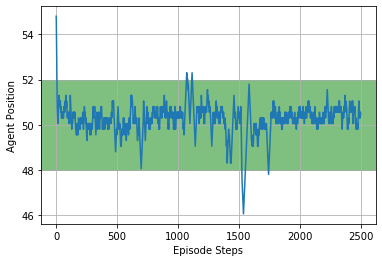

Reward of Episode 93 is -0.8088591796875


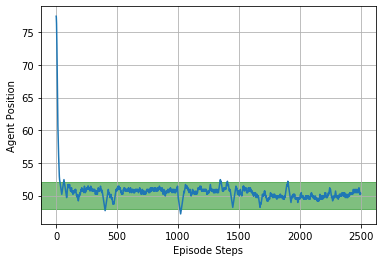

Reward of Episode 94 is -0.5301270385742187


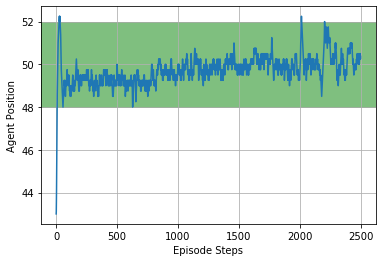

Reward of Episode 95 is -0.8158281494140625


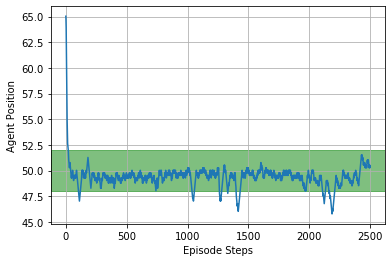

Reward of Episode 96 is -0.6975887512207031


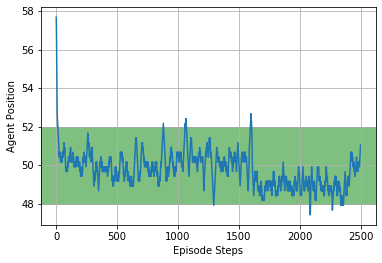

Reward of Episode 97 is -1.160062353515625


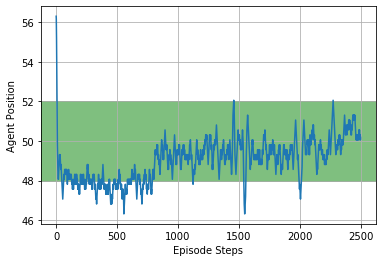

Reward of Episode 98 is -0.6840740112304687


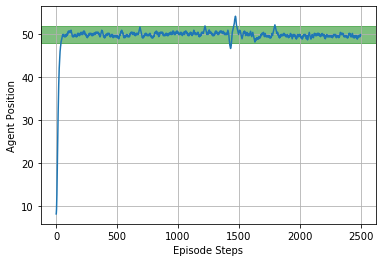

Reward of Episode 99 is -1.1709198623657227


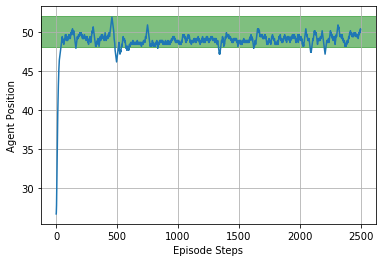

In [6]:
train_logs = agent.train(visualize=True)

In [7]:
test_logs = agent.test(visualize=False) # set visualize to True for visualization during testing 


tested for 20 episodes


Text(0, 0.5, 'Cumulative reward per step')

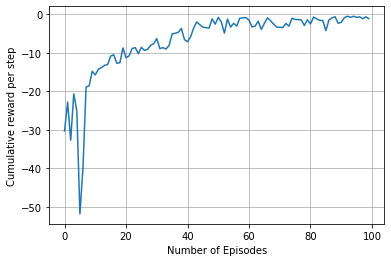

In [8]:
plt.plot(train_logs['cum_rew'])
plt.grid()
plt.xlabel("Number of Episodes")
plt.ylabel("Cumulative reward per step")

 Mean cumulative reward of entire testing is -0.43264005720615384
 Variance of cumulative reward over entire testing is 0.05584342555334656


Text(0, 0.5, 'Cumulative reward per step')

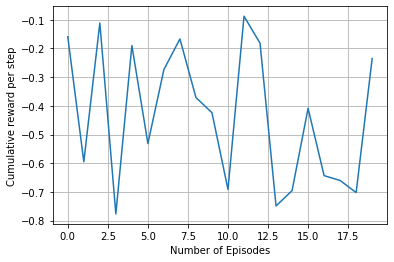

In [9]:
print(" Mean cumulative reward of entire testing is " + str(np.array(test_logs['cum_rew']).mean()))
print(" Variance of cumulative reward over entire testing is " + str(np.array(test_logs['cum_rew']).var()))
plt.plot(test_logs['cum_rew'])
plt.grid()
plt.xlabel("Number of Episodes")
plt.ylabel("Cumulative reward per step")

Result Analysis :

1) Plots of Cumulative reward per step v/s Number of episodes clearly indicate the learning policy, i.e. the agent learns to take the action such that it stays at the center of the surface.

2) To show that the model has not overfit, Testing was conducted for 20 episodes and respective cumulative reward per step vs Number of Episodes is plotted. The mean and variance of testing shows that the agent is stable.
